In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf

IMG_SHAPE = (96, 96, 1)
DATA_FOLDER = '../../datasets/SOCOFing/Altered/Altered-Easy'
images = []

if(os.path.exists(DATA_FOLDER)):
    for (dir_, dirs, files) in os.walk(DATA_FOLDER):
        for i, file in enumerate(files) :
            abs_path = dir_ + '/' + file
            if(i < 5 or i == len(files) - 1):
                print('[*] Processing file #%d : %s ' % (i+1, abs_path))
            elif(i == 5):
                print('...')
        
            img = cv2.imread(abs_path)
            img = cv2.resize(img, (IMG_SHAPE[0], IMG_SHAPE[1]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
    images = np.array(images)
    images = images.reshape(-1, IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])
else:
    print('[*] Data folder not found, please make sure that the folder exists')

[*] Processing file #1 : ../../datasets/SOCOFing/Altered/Altered-Easy/114__F_Right_index_finger_Obl.BMP 
[*] Processing file #2 : ../../datasets/SOCOFing/Altered/Altered-Easy/290__M_Left_thumb_finger_Obl.BMP 
[*] Processing file #3 : ../../datasets/SOCOFing/Altered/Altered-Easy/415__M_Left_thumb_finger_Obl.BMP 
[*] Processing file #4 : ../../datasets/SOCOFing/Altered/Altered-Easy/305__M_Right_little_finger_Obl.BMP 
[*] Processing file #5 : ../../datasets/SOCOFing/Altered/Altered-Easy/476__M_Right_index_finger_Zcut.BMP 
...
[*] Processing file #17931 : ../../datasets/SOCOFing/Altered/Altered-Easy/283__M_Right_little_finger_CR.BMP 


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### Building generator and discriminator ###
class GAN(object):
    def __init__(self, input_shape=(96, 96, 1), latent_dim=100):
        self.input_shape = input_shape
        self.latent_dim  = latent_dim
    
    def build_discriminator(self):
        inputs = Input(shape=self.input_shape)
        
        ### conv block 1 ###
        conv1 = Conv2D(32, kernel_size=(5,5), strides=2, padding='same')(inputs)
        norm1 = BatchNormalization()(conv1)
        relu1 = LeakyReLU()(norm1)
        
        ### conv block 2 ###
        conv2 = Conv2D(64, kernel_size=(5,5), strides=2, padding='same')(relu1)
        norm2 = BatchNormalization()(conv2)
        relu2 = LeakyReLU()(norm2)
        
        flatten = Flatten()(relu2)
        dropout = Dropout(0.3)(flatten)
        
        out = Dense(16, activation='relu')(dropout)
        out = Dense(1)(out)
        
        discriminator = Model(inputs=inputs, outputs=out, name='discriminator')
        return discriminator
    
    def build_generator(self):
        inputs = Input(shape=(self.latent_dim,))
        
        dense1  = Dense(24 * 24 * 32, activation='relu')(inputs)
        reshape = Reshape(target_shape=(24, 24, 32))(dense1)
        
        ### conv transpose block 1 -> shape=(48, 48, 64) ###
        conv1 = Conv2DTranspose(64, kernel_size=(5,5), strides=2, padding='same')(reshape)
        norm1 = BatchNormalization()(conv1)
        
        ### conv transpose block 2 -> shape=(96, 96, 128) ###
        conv2 = Conv2DTranspose(128, kernel_size=(5,5), strides=2, padding='same')(norm1)
        norm2 = BatchNormalization()(conv2)
        
        ### Final convT to retrieve original image depth ###
        out = Conv2D(1, kernel_size=(5,5), strides=1, padding='same')(norm2)
        
        generator = Model(inputs=inputs, outputs=out, name='generator')
        return generator
    
gan = GAN()
g = gan.build_generator()
d = gan.build_discriminator()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 18432)             1861632   
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 48, 48, 64)        51264     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 96, 96, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 128)       51

In [13]:
### Now start training ###
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

EPOCHS = 50
BATCH_SIZE = 64
G_CHECKPOINT = 'checkpoints/g_finger.weights.hdf5'
D_CHECKPOINT = 'checkpoints/d_finger.weights.hdf5'

g_opt = Adam(1e-4, amsgrad=True)
d_opt = Adam(1e-4, amsgrad=True)

def generator_loss(fake_output):
    ones = tf.ones_like(fake_output)
    loss = K.binary_crossentropy(ones, fake_output, from_logits=True)
    
    return loss

def discriminator_loss(real_output, fake_output):
    ones = tf.ones_like(real_output)
    zeros = tf.zeros_like(fake_output)
    
    real_loss = K.binary_crossentropy(ones, real_output, from_logits=True)
    fake_loss = K.binary_crossentropy(zeros, fake_output, from_logits=True)
    loss = real_loss + fake_loss
    
    return loss

@tf.function
def train_step(images):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        noise = K.random_normal(stddev=1.0, shape=(images.shape[0], gan.latent_dim))
        generated_images = g(noise, training=True)
        fake_output = d(generated_images, training=True)
        real_output = d(images, training=True)
        
        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)
        
    g_gradients = g_tape.gradient(g_loss, g.trainable_variables)
    d_gradients = d_tape.gradient(d_loss, d.trainable_variables)
    
    g_opt.apply_gradients(zip(g_gradients, g.trainable_variables))
    d_opt.apply_gradients(zip(d_gradients, d.trainable_variables))
    return K.mean(g_loss), K.mean(d_loss)

num_batches = images.shape[0] // BATCH_SIZE
print('[*] Training starts ... ')
if(os.path.exists(G_CHECKPOINT)):
    print('[*] Loading generator checkpoint ...')
    g.load_weights(G_CHECKPOINT)

if(os.path.exists(D_CHECKPOINT)):
    print('[*] Loading discriminator checkpoint ...')
    d.load_weights(D_CHECKPOINT)
    
for i in range(EPOCHS):
    for j in range(num_batches):
        batch = images[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
        g_loss, d_loss = train_step(batch)
        
    print('[*] Epochs #{}, generator loss = {:.2f}, discriminator_loss = {:.2f}'.format(i+1, g_loss, d_loss))
    if((i+1) % 10 == 0):
        print(' [*] Checkpointing generator and discriminator...')
        g.save_weights(G_CHECKPOINT)
        d.save_weights(D_CHECKPOINT)

[*] Training starts ... 
[*] Epochs #1, generator loss = 7.07, discriminator_loss = 0.08
[*] Epochs #2, generator loss = 6.48, discriminator_loss = 0.02
[*] Epochs #3, generator loss = 5.38, discriminator_loss = 0.16
[*] Epochs #4, generator loss = 6.00, discriminator_loss = 0.15
[*] Epochs #5, generator loss = 7.36, discriminator_loss = 0.07
[*] Epochs #6, generator loss = 6.16, discriminator_loss = 0.05
[*] Epochs #7, generator loss = 5.18, discriminator_loss = 0.04
[*] Epochs #8, generator loss = 6.31, discriminator_loss = 0.05
[*] Epochs #9, generator loss = 5.57, discriminator_loss = 0.11
[*] Epochs #10, generator loss = 5.70, discriminator_loss = 0.05
 [*] Checkpointing generator and discriminator...
[*] Epochs #11, generator loss = 4.90, discriminator_loss = 0.17
[*] Epochs #12, generator loss = 2.57, discriminator_loss = 0.34
[*] Epochs #13, generator loss = 4.89, discriminator_loss = 0.11
[*] Epochs #14, generator loss = 4.53, discriminator_loss = 0.11
[*] Epochs #15, generato

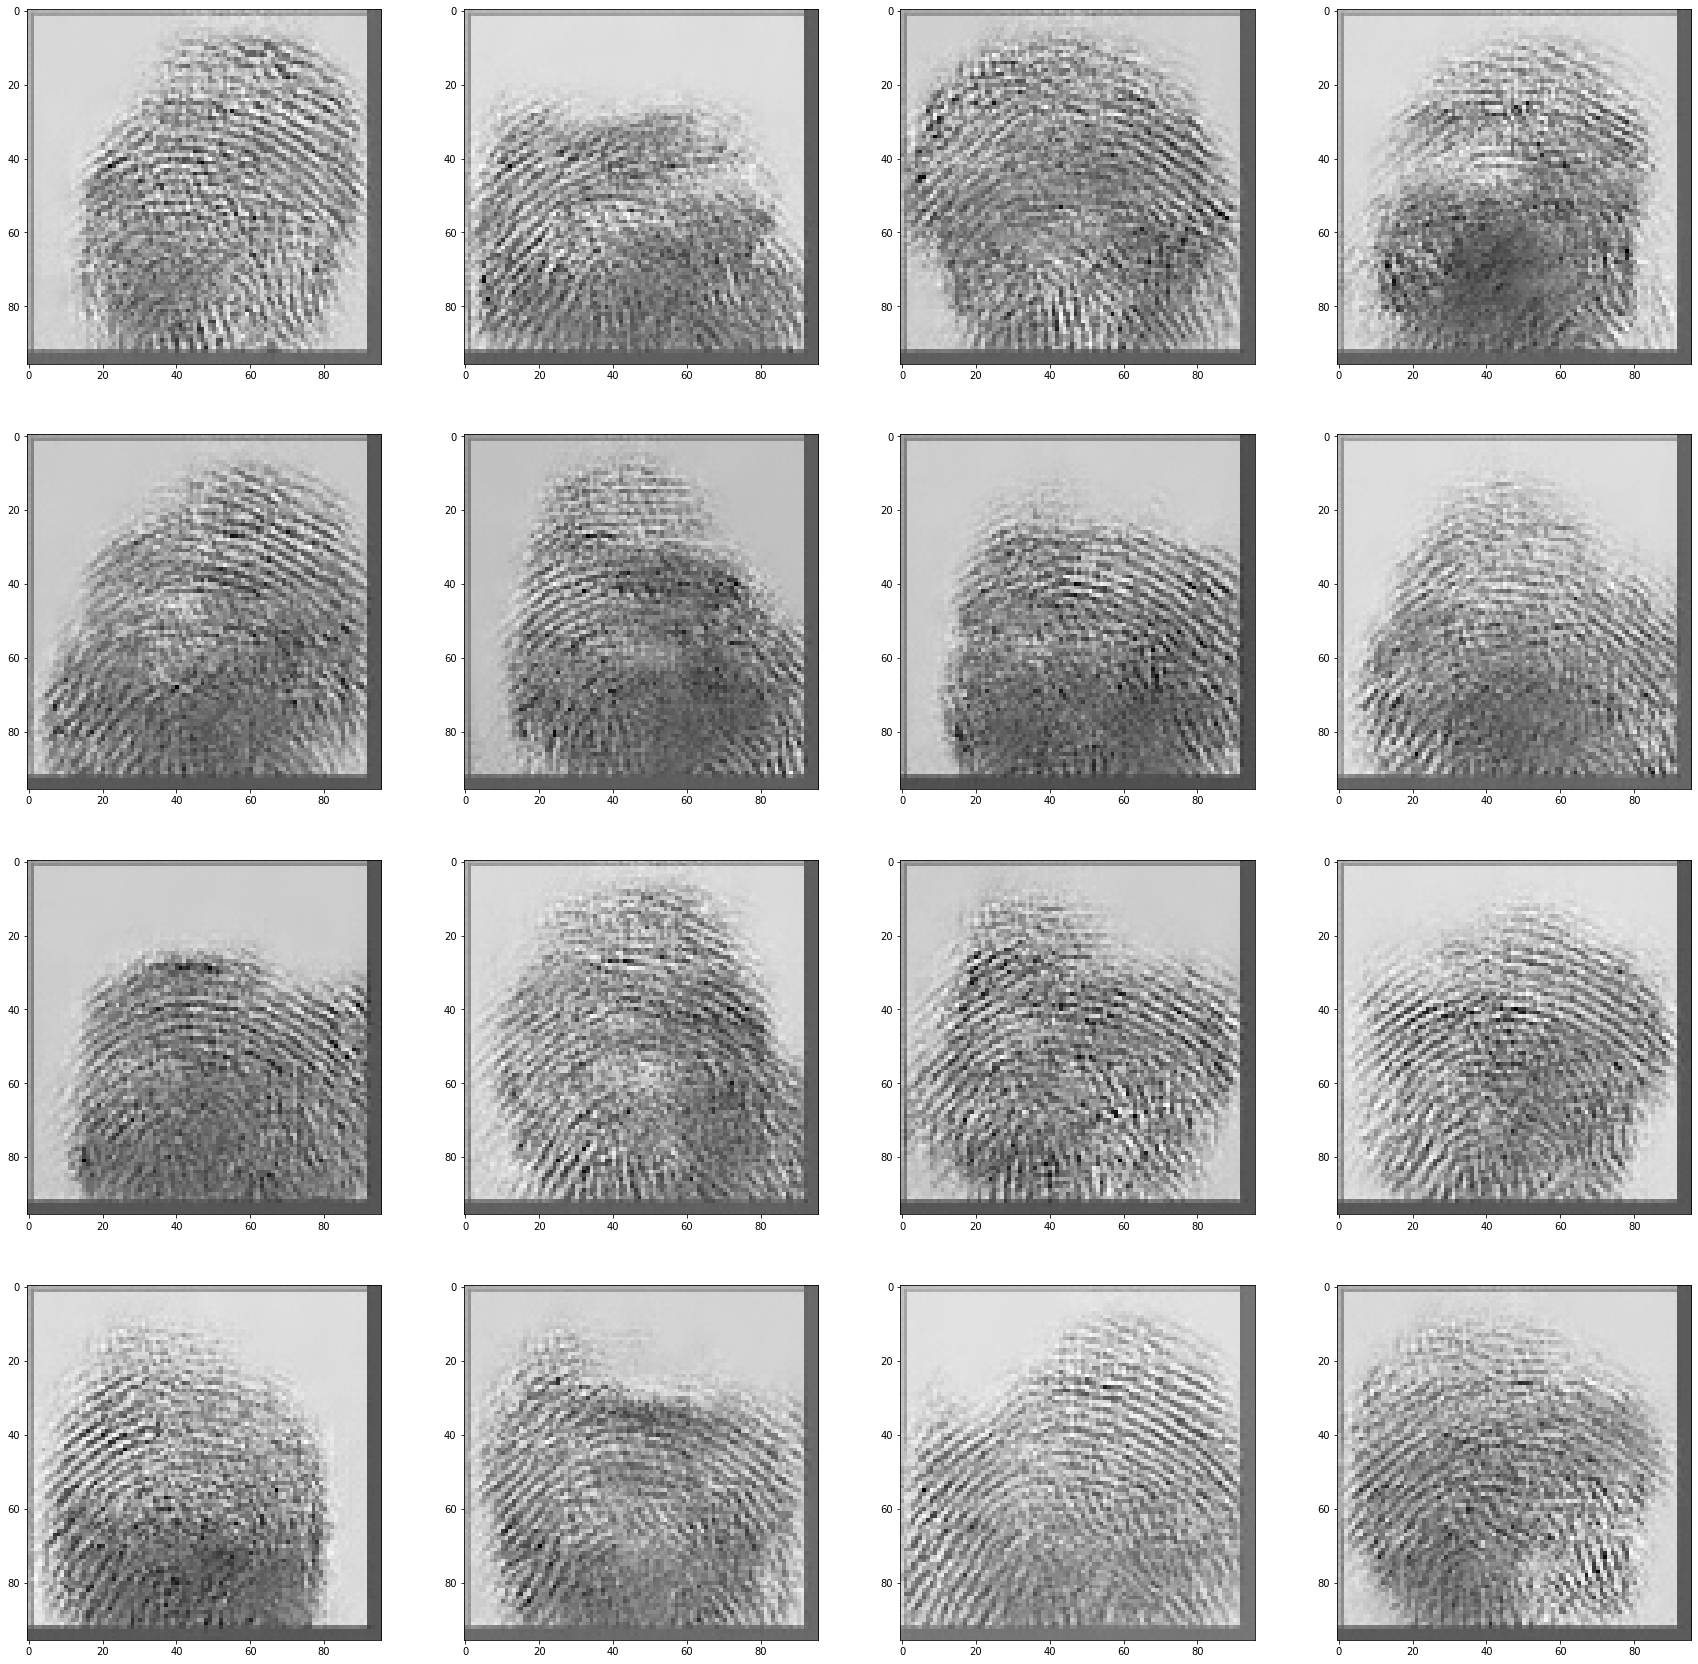

In [19]:
### Testing generator ###
import tensorflow as tf
import matplotlib.pyplot as plt

### Load generator's weights in case not loaded ###
if(os.path.exists(G_CHECKPOINT)):
    g.load_weights(G_CHECKPOINT)
    
NUM_IMG = 16
NUM_ROW = 4

noise = tf.random.normal(shape=(NUM_IMG, gan.latent_dim))
predictions = g.predict(noise)

fig, ax = plt.subplots(NUM_ROW, NUM_ROW, figsize=(30,30))
for i in range(NUM_IMG):
    row = i // NUM_ROW
    col = i %  NUM_ROW
    ax[row][col].imshow(predictions[i], cmap='Greys_r')
    
plt.show()